# Convolutional Neural Network for Eye Diseases Classification
In this notebook, we implement transfer learning using pre-trained convolutional neural networks for eye disease classification. We leverage models such as DenseNet169 that have been pre-trained on ImageNet to benefit from learned feature representations.

## Imports

In [19]:
import os
import torch
import torchvision
import opendatasets as od
import wandb
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
from torchvision.models import densenet169, DenseNet169_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Loading and Exploration
We download the eye diseases classification dataset and prepare the data for training, validation, and testing. Transformations include resizing images to 256x256 (compatible with pre-trained models) and normalization with ImageNet statistics to ensure compatibility with the pre-trained weights.

Splitting is done with 80% for training, 10% for validation, and 10% for testing. Custom subsets wrap the dataset to apply different transformations for train and test/validation sets.

In [20]:
od.download("https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification")

Skipping, found downloaded files in ".\eye-diseases-classification" (use force=True to force download)


In [21]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Using ImageNet statistics
    ])

transform_test_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [22]:
full_dataset = torchvision.datasets.ImageFolder(root='eye-diseases-classification/dataset')

## Custom Subset with Transforms

The default Subset does not apply transformations, so we wrap it in a custom class that applies transforms in the moment.

In [23]:
class TransformedSubset:
    def __init__(self, subset: Subset, transform: transforms.Compose):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index: int) -> tuple:
        img, label = self.subset[index]
        img = self.transform(img)
        return img, label
    
    def __len__(self) -> int:
        return len(self.subset)

## Dataset Splitting
We shuffle the indices using a fixed seed for reproducibility and split the dataset into training, validation, and test sets with proportions of 80%, 10%, and 10%, respectively.

In [24]:
np.random.seed(42)
index = np.arange(len(full_dataset))
np.random.shuffle(index)

train_percent = 0.8
test_val_percent = 0.1

train_index = int(train_percent * len(full_dataset))
test_val_index = int((train_percent + test_val_percent) * len(full_dataset))

dataset_train = TransformedSubset(Subset(full_dataset, index[:train_index]), transform_train)
dataset_val = TransformedSubset(Subset(full_dataset, index[train_index:test_val_index]), transform_test_val)
dataset_test = TransformedSubset(Subset(full_dataset, index[test_val_index:]), transform_test_val)

## DataLoader Creation
Finally, we create de DataLoaders for train, validation and test to generate batches during training and evaluation.

In [25]:
train_loader = DataLoader(dataset_train, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=40, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=40, shuffle=True)

## Visualizate Images of Dataset
Before training, we visualize a sample of images from the dataset to understand the diversity and characteristics of the eye disease classes. This helps verify that the data has been loaded correctly and provides insight into the classification task.

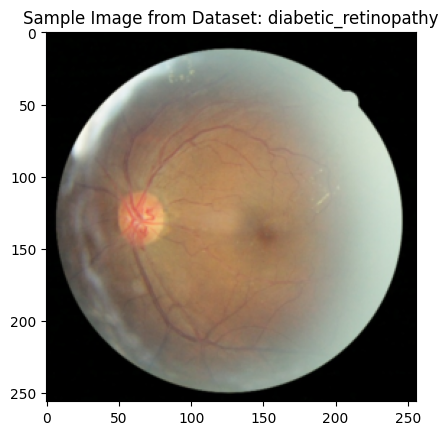

In [26]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
idx = random.randint(0, images.shape[0] - 1)
image = images[idx].numpy()
image = np.transpose(image, (1, 2, 0)) # For matplotlib we need to change the shape

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean 
image = np.clip(image, 0, 1)

plt.title("Sample Image from Dataset: {class_name}".format(class_name=full_dataset.classes[labels[idx].item()]))
plt.imshow(image)
plt.show()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Structure of Convolutional Neural Network
We utilize transfer learning by loading pre-trained models and adapting them for our specific classification task. The pre-trained convolutional layers serve as feature extractors, while we replace the final classification layer to match the number of eye disease classes in our dataset.

Transfer learning involves two main strategies:
1. **Feature extraction**: Freeze the pre-trained layers and only train the new classification head
2. **Fine-tuning**: Unfreeze some or all pre-trained layers and continue training with a lower learning rate

We experiment with both approaches to find the optimal balance between leveraging pre-trained features and adapting to our specific dataset.

In [28]:
classes = full_dataset.classes
num_classes = len(classes)

weights = DenseNet169_Weights.DEFAULT
model = densenet169(weights=weights)

in_features = model.classifier.in_features

class CustomHead(nn.Module):        
    def __init__(self, in_features, num_classes):
        super(CustomHead, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model.classifier = CustomHead(in_features, num_classes)
model = model.to(device)    

for name, param in model.features.named_parameters():
    if "denseblock3" in name or "denseblock4" in name or "norm5" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


## Optimizer
Here we configure the optimizer and loss function. We also set up learning rate scheduling to prevent overfitting.

In [ ]:
optimizer = optim.Adamax(model.parameters(), lr=0.001)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
)

## Prove the Convolutional Neural Network

### Setup and Initialization of CNN

We track metrics such as loss and accuracy across all three phases and use Weights & Biases (wandb) for experiment tracking.

In [30]:
wandb.init(
    project="eye-disease-classification",
    name="transfer_learning_cnn",
    config={
        "learning_rate": 0.001,
        "epochs": 200,
        "batch_size": 40,
        "architecture": "transfer_learning_densenet169"
    }
)

In [31]:
save_path = "models/transfer_learning" # Where the plots and best model is going to save
os.makedirs(save_path, exist_ok=True)

### Training, Validation and Testing of the CNN

The training pipeline includes:
- **Training phase**: Forward pass, loss computation, backpropagation, and parameter updates
- **Validation phase**: Evaluating performance on unseen validation data after each epoch to monitor overfitting
- **Testing phase**: Final evaluation on the test set to assess model generalization

In [32]:
epochs = 200
early_stopping_criteria = 25
early_stopping_counter = 0

best_val_accuracy = 0.0
min_val_loss = float('inf')

total_val_loss = []
total_train_loss = []
total_val_accuracy = []
total_training_accuracy = []

for epoch in range(epochs):

    # TRAIN
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    total_train_loss.append(train_loss)
    train_accuracy = 100 * train_correct / train_total
    total_training_accuracy.append(train_accuracy)
    
    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0) 
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    total_val_loss.append(val_loss)
    val_accuracy = 100 * val_correct / val_total
    total_val_accuracy.append(val_accuracy)
    
    scheduler.step(val_loss)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_criteria:
        print(f'Early stopping at epoch {epoch+1}')
        break

    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.2f}%')
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    # Log in WanDB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "learning_rate": current_lr
    })

Epoch 1/200 - Train Loss: 0.6374, Train Acc: 85.56%, Val Loss: 0.5348, Val Acc: 89.57%
Epoch 2/200 - Train Loss: 0.4782, Train Acc: 93.83%, Val Loss: 0.4871, Val Acc: 94.31%
Epoch 3/200 - Train Loss: 0.4243, Train Acc: 96.98%, Val Loss: 0.5081, Val Acc: 92.65%
Epoch 4/200 - Train Loss: 0.3978, Train Acc: 98.37%, Val Loss: 0.5273, Val Acc: 93.13%
Epoch 5/200 - Train Loss: 0.3917, Train Acc: 98.43%, Val Loss: 0.4996, Val Acc: 92.18%
Epoch 6/200 - Train Loss: 0.3728, Train Acc: 99.35%, Val Loss: 0.5171, Val Acc: 92.42%
Epoch 7/200 - Train Loss: 0.3657, Train Acc: 99.58%, Val Loss: 0.5106, Val Acc: 92.89%
Epoch 8/200 - Train Loss: 0.3578, Train Acc: 99.94%, Val Loss: 0.4983, Val Acc: 93.13%
Epoch 9/200 - Train Loss: 0.3562, Train Acc: 99.91%, Val Loss: 0.4857, Val Acc: 93.84%
Epoch 10/200 - Train Loss: 0.3547, Train Acc: 99.88%, Val Loss: 0.4978, Val Acc: 93.84%
Epoch 11/200 - Train Loss: 0.3543, Train Acc: 99.85%, Val Loss: 0.5021, Val Acc: 93.60%
Epoch 12/200 - Train Loss: 0.3539, Train 

In [33]:
model.load_state_dict(torch.load(os.path.join(save_path, 'best_model.pth')))

model.eval()
test_correct = 0
test_total = 0
y_pred = []
y_true = []

# TEST
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy of the model on test images: {test_accuracy:.2f}%')

wandb.log({"test_accuracy": test_accuracy})
wandb.finish()      

Accuracy of the model on test images: 94.79%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,███████▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
train_accuracy,▁▅▇▇▇███████████████████████████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▅▆▄▅▅▆▇▆▇▇▆█▇▇▇▇▇▇▇█▆█▇███▇▇▇▆▇▇▇▇▇▇▇█
val_loss,█▁▄▇▃▆▅▃▃▃▂▃▂▃▂▃▂▂▁▁▃▁▁▂▃▃▂▃▄▅▃▂▃▃▂▃▃▄▃▃
epoch,45
learning_rate,2e-05
test_accuracy,94.78673
train_accuracy,99.88141


### Graphics
Visual analysis of training results helps identify potential issues such as overfitting, underfitting, or convergence problems. We generate plots showing the progression of loss and accuracy metrics throughout training

#### Confusion Matrix
The confusion matrix provides a detailed breakdown of model predictions versus actual labels for each class. This visualization helps identify which eye disease classes are most frequently confused with each other, revealing potential areas for model improvement or data augmentation.

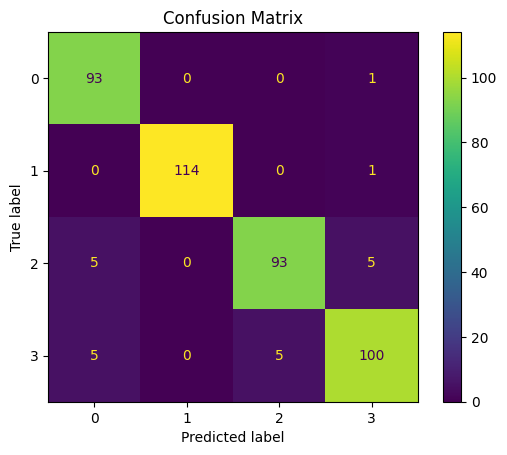

In [34]:
cm = confusion_matrix(y_pred, y_true)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix")
plt.savefig(os.path.join(save_path, "confusion_matrix.png"))
plt.show()

### Loss And Accuracy Graphics
We plot training and validation loss/accuracy curves over epochs to visualize the learning process. Key observations include:
- **Convergence**: Whether the model reaches a stable performance
- **Overfitting**: Gap between training and validation metrics
- **Optimal stopping point**: The epoch where validation performance peaks

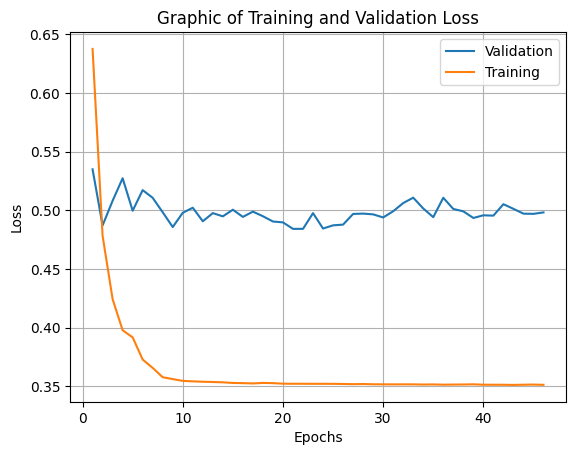

In [35]:
plt.plot(range(1, len(total_val_loss)+1), total_val_loss, label='Validation')
plt.plot(range(1, len(total_train_loss)+1), total_train_loss, label='Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphic of Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "loss_graphic.png"))
plt.show()


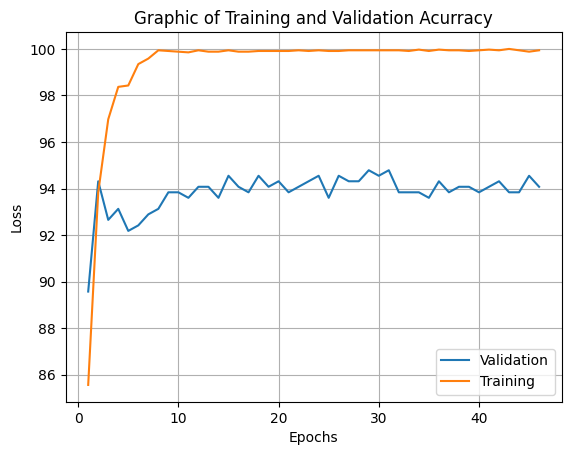

In [36]:
plt.plot(range(1, len(total_val_loss)+1), total_val_accuracy, label='Validation')
plt.plot(range(1, len(total_val_loss)+1), total_training_accuracy, label='Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphic of Training and Validation Acurracy')
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "accuracy_graphic.png"))
plt.show()